In [2]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Heart Disease and Age

Introduction

Background Information

Heart disease is a broad range of diseases that affects an individual's heart and blood vessels.

These diseases can be influenced by many factors, including underlying health conditions and lifestyle choices.


The Question

Can the age of an individual with heart disease be predicted by the severity of their symptoms?

The Dataset

We are using the “Heart Disease” dataset. This dataset describes a range of attributes, as well as an indication as to the presence of heart disease within each individual. The specific datasets we will be analyzing contains a subset of 14 main attributes, including information about a patient’s sex, age, symptoms, and diagnosis.

https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Preliminary Exploratory Data Analysis

In [3]:
#The data can be read through the file as seen below
van_data_csv <- read_csv("data/processed.van.csv", col_names =
               c("age", "sex", "chest_pain", "trestbps", "chol",
               "fbs",  "restecg", "thalach", "exang", "oldpeak", 
               "slope", "ca", "thal", "num")) %>%
                filter(!is.na(restecg)) %>%
                filter(!is.na(chol)) %>%
                filter(!is.na(trestbps))

van_data <- van_data_csv %>%
             select(age, restecg, trestbps, chol)

head(van_data)


Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, thalach, exang, oldpeak, slope, ca, thal
dbl (5): age, sex, chest_pain, restecg, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,restecg,trestbps,chol
<dbl>,<dbl>,<chr>,<chr>
63,1,140,260
44,1,130,209
60,1,132,218
55,1,142,228
66,2,110,213
66,1,120,0


In [ ]:
#insert initial graphs found from simply comparing age vs...
#EXPLAIN SIGNIFICANCE 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



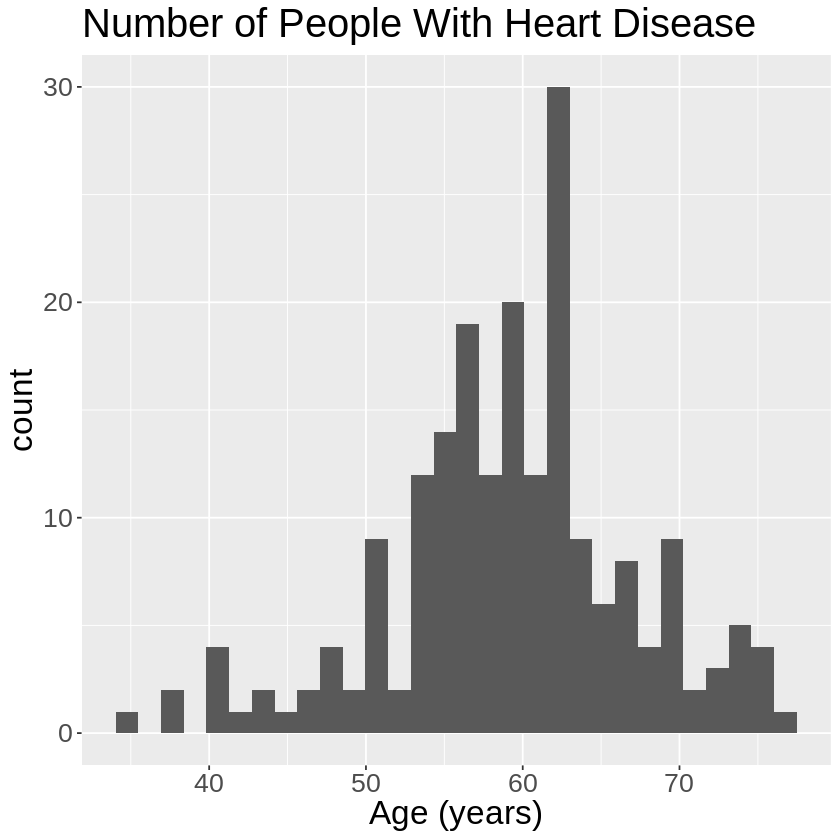

In [4]:
van_plot_hist <- ggplot(van_data, aes(x = age)) + 
            geom_histogram() + 
            labs(x = "Age (years)", title = "Number of People With Heart Disease") + 
            theme( text = element_text(size = 20)) 
van_plot_hist

Through this histogram, we can see a correlation between age, and the quantity of people that contract heart disease. The majority of those with heart disease are bewteen the ages of 55 and 65.

In [6]:
#split data into training and testing set
#organize training set... perhaps calculate any averages or other such steps here? Could you maybe find average cholesterol per age group????
#input preliminary knn classification system, analyze correlations if any.

Methods

With the following variables, we will create a KNN Classification model to predict age.
- Resting Electrocardiographic Results
- Cholesterol Levels
- Resting Blood Pressure

The KNN classification model will need to be trained, evaluated, and tuned with both training and testing sets before we are able to predict the age of a new patient. We will need to break up the data into different age groups, and compare these with each of the predictor variables. In addition, we can test our model with the other datasets provided, as they contain the same variables, bit are from different locations.

Expected Outcome and Significance

We expect to see a positive correlation between the age of an individual, and the severity of their symptoms. As people age, they can become affected by disease and other ailments more easily. Conversely, lower age groups will experience less severe symptoms.

Understanding the relationship between age and symptoms could help medical professionals understand what to look for in a given patient. Additionally, it can help provide information as to when an individual should seek out more frequent check-ups.

The analysis could also prompt further questions:
- What are the risk factors of heart disease?
- What are early signs of heart disease in a young invdividual? In an old individual.
